### Load in DESeq2 Results

As mentioned, I ran DESeq2 in a separate notebook. I ran two tests, one that just compares every stim to the control for every non-zero time point (labeled by the hour in the cell below), and another that tries to model stimulation-specific changes over time (labeled as TC below). I'll read in all, but since I'm not *exactly* sure how to interpret the latter, I'm really only going to focus on the former in this notebook.

In [99]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy

And then some from the [goatools](https://github.com/tanghaibao/goatools) Gene Ontology package for Python. Most of the code here modeled after the [notebooks](https://github.com/tanghaibao/goatools#ipython-notebooks) found on the Github.

In [100]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_hum
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [101]:
prefix = '/data/codec/production.run/mrna/'

In [102]:
conds_1 = ['A', 'B', 'G', 'P', 'R']
cts_1 = ['B_Memory', 'B_Naive', 'CD4_T_Memory', 'CD4_T_Naive', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Naive', 'HSC', 'NK', 'pDC','Mono_cDC_All']

Read in the results.

In [103]:
de = dict() # differential expression dictionary
for cond in conds_1:
    de[cond] = dict()
    
combos = it.product(conds_1, cts_1)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

In [104]:
conds_2 = ['A', 'B', 'G', 'R']
cts_2 = ['Mono_C', 'Mono_NC', 'cDC']

In [105]:
combos = it.product(conds_2, cts_2)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

### Plot The Positive Half of the Volcano Plot for Any Sample

Just focusing on those genes that were increased in expression relatively to control.

In [106]:
stim = 'R'
ct = 'B_Memory'

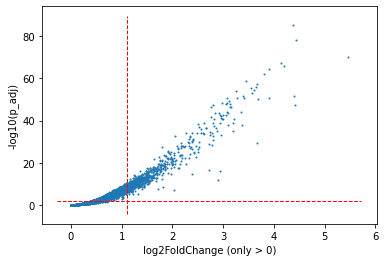

In [107]:
df = de[cond][ct]
df = df[df['log2FoldChange'] > 0]
fc_thresh = np.percentile(df['log2FoldChange'],90)

plt.scatter(df['log2FoldChange'].values, 
            -np.log10(df['padj']).values,
           s=1);

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()


#########################################################################################################
# Through testing with multiple samples, I think a good metric for determining differentially expressed genes involves a strict p_adj value cutoff (0.05) 
# and a dynamic log fold change threshold that changes depending on the sample. I'm using the log2foldchange value at the 90th %ile of positive values
#########################################################################################################

# drawing cutoffs here
plt.plot(xlim, [-np.log10(0.01)]*2, linewidth=1, c='r', linestyle='--');
plt.plot([fc_thresh]*2, ylim, linewidth=1, c='r', linestyle='--');

plt.xlabel('log2FoldChange (only > 0)')
plt.ylabel('-log10(p_adj)');

### Get Pseudobulks

In [108]:
pseudobulk = pd.read_pickle(prefix + 'pkls/aggr/pseudobulk.cts.pkl')
# this object is a pseudobulk (sum) over all the cells in a particular condition in a particular condition
# summing makes sense over all the cells, but to get a measure of centrality for each condition-cell type, I will take the *mean* of individuals

In [109]:
ct_cond_combos = list(it.product(cts_1, conds_1)) + list(it.product(cts_2, conds_2))

In [110]:
pseudobulk_conds_cts_list = list()
for ct, cond in tqdm(ct_cond_combos):
    mean_ind = pseudobulk[(pseudobulk['CT'] == ct) & (pseudobulk['COND'] == cond)].iloc[:,3:].mean(0).values.tolist()
    pseudobulk_conds_cts_list.append([ct, cond] +  mean_ind)

In [111]:
pseudobulk_conds_cts = pd.DataFrame(pseudobulk_conds_cts_list, columns = ['CT', 'COND'] + pseudobulk.columns.tolist()[3:])

In [112]:
# Just confirm that no genes have counts of zero.
(pseudobulk_conds_cts.iloc[:,2:].sum(0) == 0).sum() == 0

True

## DE Genes: 2-sided, Static Cutoffs

Using a static cutoff for LFC and strict p_adj < 0.01, I will now extract out differentially expressed genes. At Hyun's suggestion, using only the top _n_ significant genes from each comparison, since some conditions like PMAI and R848 have 1000s, while TNF-alpha conditions have in the 10s or 100. Using the top 200 from each condition will not bias the heatmap towards the most stimulating conditions.

In [113]:
de_genes = dict() # make a dictionary

num_top_genes_to_keep = 200
for ct, cond in ct_cond_combos: 
    try:
        de_genes[ct]
    except KeyError:
        de_genes[ct] = dict()

    df = de[cond][ct] # get the DE results
    df = df[(df['log2FoldChange'] > 2) | (df['log2FoldChange'] < -2)]
    
    # extract out genes, add them to the dictionary as a list
    df_significant = df[(df['padj'] < 0.05)]
    de_genes[ct][cond] = df.sort_values('padj').index[:num_top_genes_to_keep]

all_de_genes = list()
lengths = list()
for ct, cond in ct_cond_combos:
    de_genes_list = de_genes[ct][cond]
    length = len(de_genes_list)
    lengths.append(length)
#     print((ct, cond, length))
    all_de_genes.append(de_genes[ct][cond])

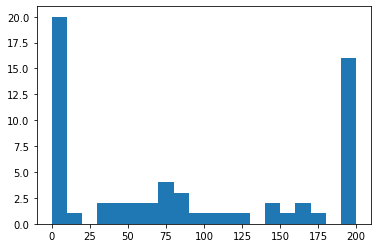

In [114]:
plt.hist(lengths, bins=20);

In [115]:
all_de_genes = np.unique([i for j in all_de_genes for i in j])

Turn the counts matrix into an adata object for easy processing like normalize, log1p, and scaling.

In [19]:
counts_for_heatmap = pseudobulk_conds_cts.iloc[:,2:]
obs = pd.DataFrame(index=pseudobulk_conds_cts['CT'] + '-' + pseudobulk_conds_cts['COND'])
var = pd.DataFrame(index=pseudobulk_conds_cts.iloc[:,2:].columns)

In [20]:
adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

In [21]:
adata

AnnData object with n_obs × n_vars = 62 × 20303

In [22]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [23]:
adata.raw = adata.copy()

In [24]:
sc.pp.log1p(adata)

In [25]:
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [26]:
df_de = pd.DataFrame(adata[:,all_de_genes].X, index=obs.index, columns=all_de_genes)

In [27]:
df_de.shape

(62, 1583)

## Plotting

### Clustering by Tree Cut

#### Naive Coloring

Better to separately make the linkage matrix, becuase I'm going to want to cluster the genes based on it.

In [28]:
Z = scipy.cluster.hierarchy.linkage(df_de.T, method='average', optimal_ordering=True)

Gotta love scanpy's colors:

In [29]:
num_modules = 100
color_dict = dict(zip(range(num_modules),sc.pl.palettes.default_102))

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


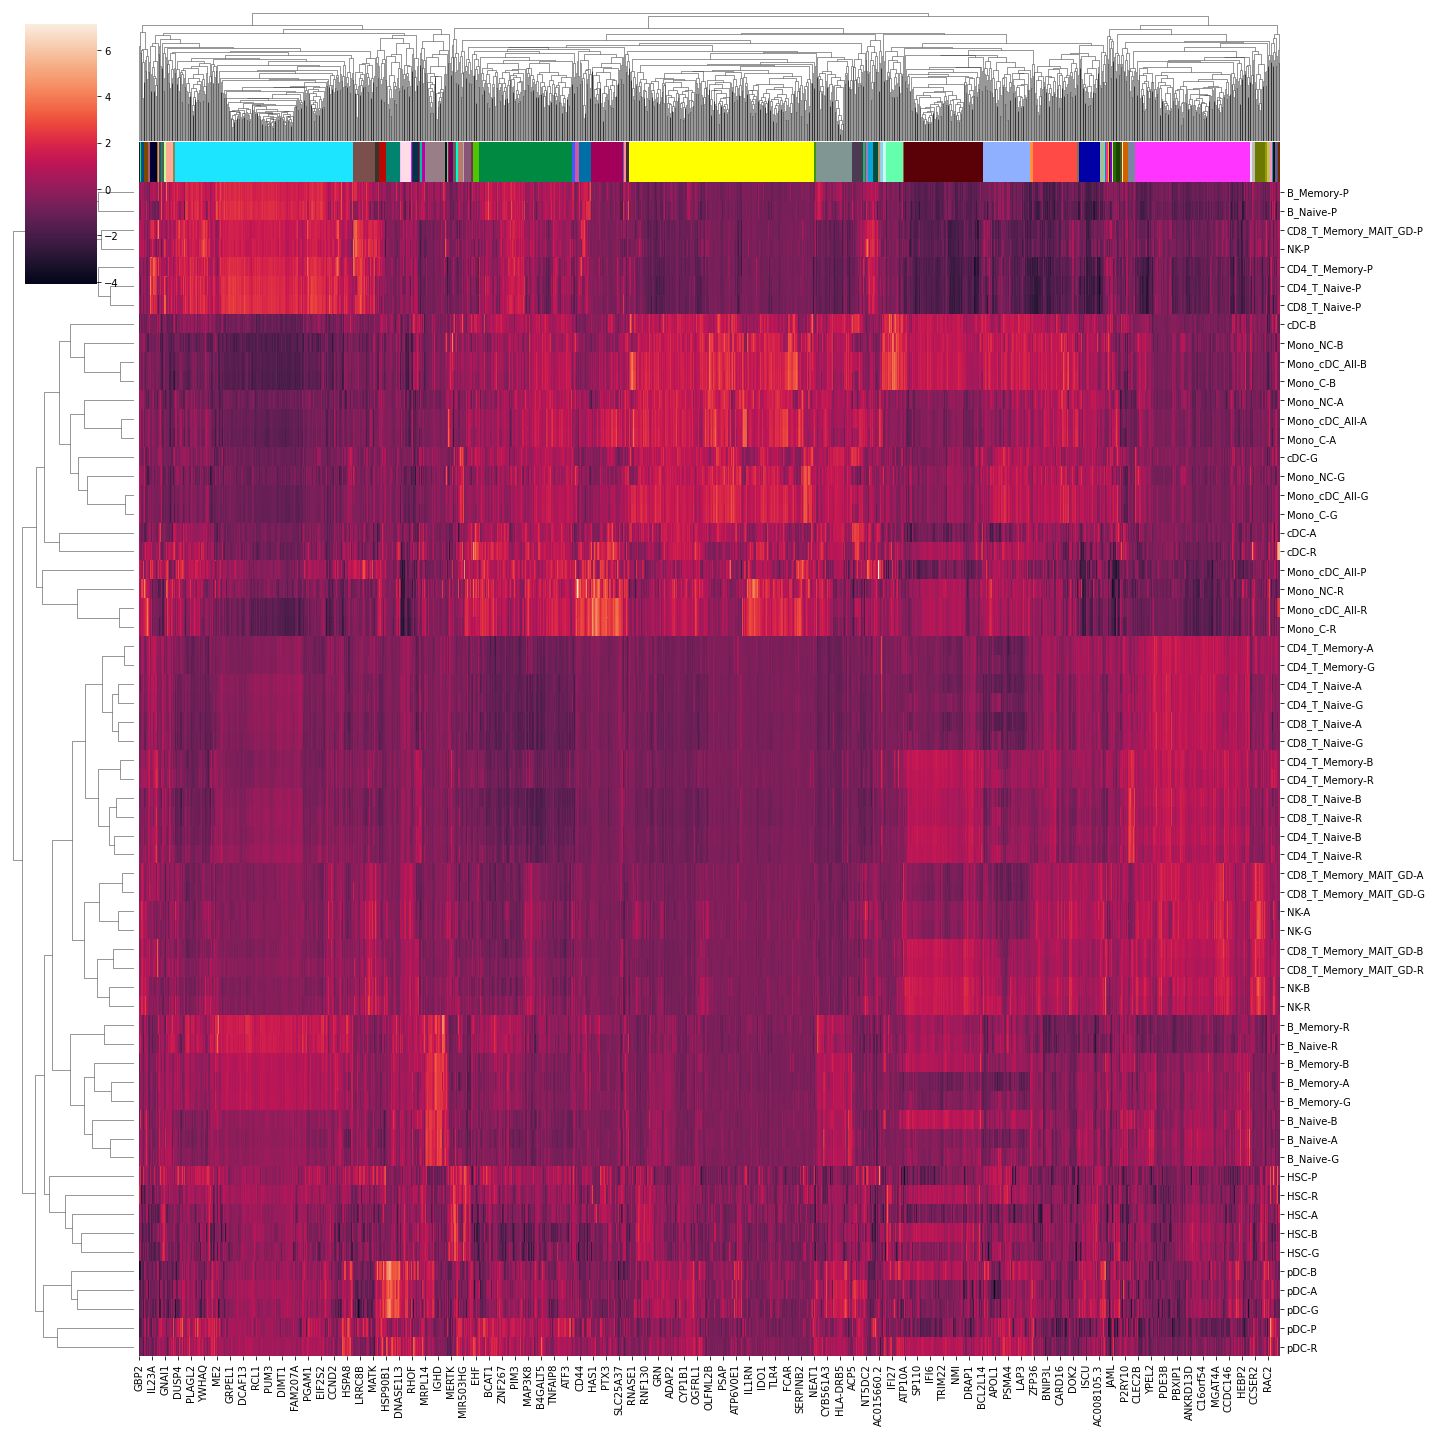

In [30]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()
sns.clustermap(df_de, figsize=(20,20), 
               row_cluster=True,
               col_linkage=Z, 
               col_colors=list(map(lambda x: color_dict[x], modules)),
               dendrogram_ratio=0.1,
              );
# plt.tight_layout()

#### Get Labels and Color according to Size

In [31]:
# credit to user Has QUIT--Anony-Mousse from https://stackoverflow.com/questions/12572436/calculate-ordering-of-dendrogram-leaves
n = len(Z) + 1
cache = dict()
for k in range(len(Z)):
    c1, c2 = int(Z[k][0]), int(Z[k][1])
    c1 = [c1] if c1 < n else cache.pop(c1)
    c2 = [c2] if c2 < n else cache.pop(c2)
    cache[n+k] = c1 + c2
ordering = cache[2*len(Z)]

In [32]:
# cmap = mpl.cm.get_cmap('prism')

In [33]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()[ordering]

In [34]:
module_vals, module_counts = np.unique(modules, return_counts=True)

In [35]:
modules_size_ordered = pd.DataFrame(data=zip(module_vals, module_counts),
                                    columns=['v','c']).sort_values('c', ascending=False)['v'].values

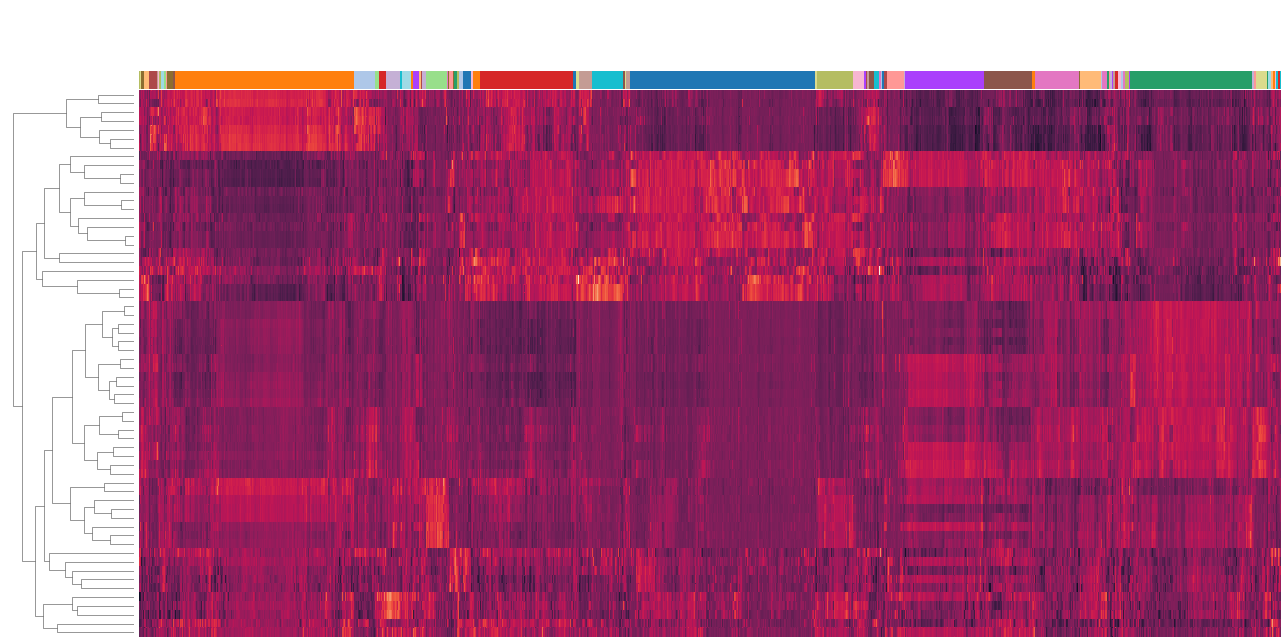

In [36]:
color_dict = dict(zip(modules_size_ordered,sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))))
genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

#### Module Identification

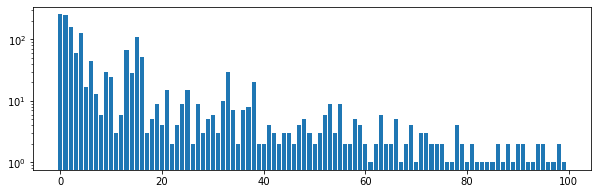

In [37]:
plt.figure(figsize=(10,3))
plt.bar(module_vals, module_counts);#, s=5);
plt.yscale('log');

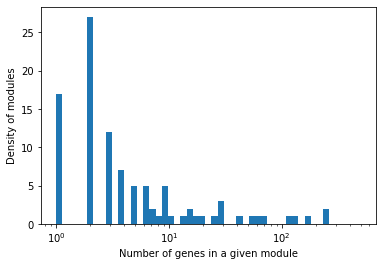

In [38]:
plt.hist(module_counts, bins=np.logspace(np.log10(1), np.log10(500), 50));
plt.xscale('log')
plt.xlabel('Number of genes in a given module')
plt.ylabel('Density of modules');

Only want to keep the main modules:

In [39]:
main_modules = np.arange(num_modules)[module_counts > 5]
main_modules_genes = dict()
for module in main_modules:
    main_modules_genes[module] = genes[modules == module]

In [40]:
len(main_modules_genes)

32

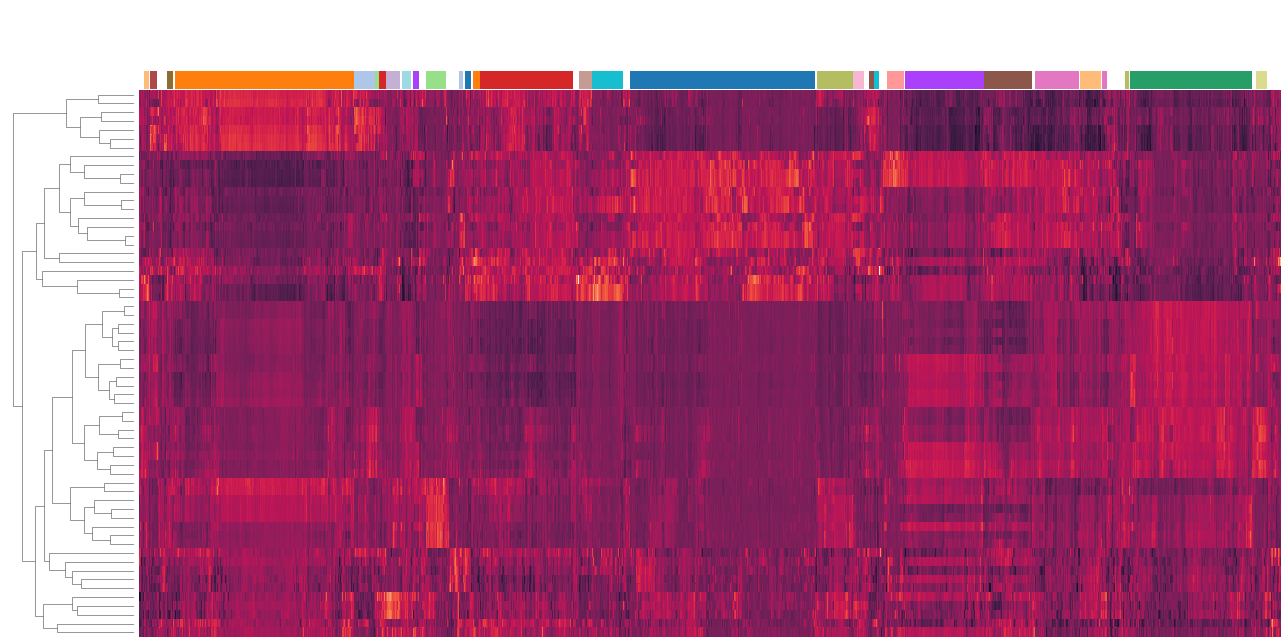

In [41]:
colorful_colors = sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))
colors = colorful_colors[:len(main_modules_genes)] + ['#FFFFFF']*(num_modules-len(main_modules_genes))
color_dict = dict(zip(modules_size_ordered, colors))

genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

Visualize the colors for the modules.

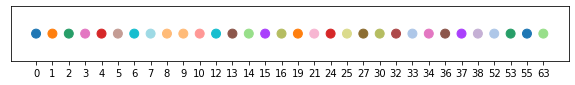

In [42]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

### Clustering by KMeans

In [43]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

Code for finding optimal k taken from [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

In [44]:
distortions = list()
K = np.concatenate(([1],np.arange(5,105,5)))
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(df_de.T)
    kmeanModel.fit(df_de.T)
    distortions.append(sum(np.min(cdist(df_de.T, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_de.T.shape[0])

In [45]:
rise = [distortions[i] - distortions[i - 1] for i in range(1, len(K))]
run = [K[i] - K[i - 1] for i in range(1, len(K))]
slopes = np.array([-i/j for i, j in zip(rise, run)])

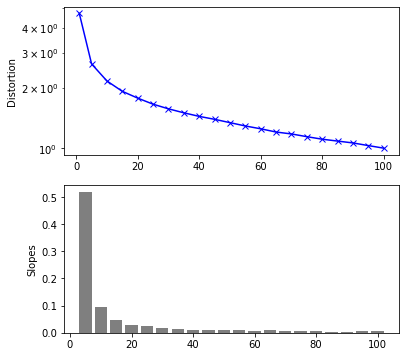

In [46]:
# Plot the elbow
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(K, distortions - min(distortions) + 1, 'bx-')
ax[0].set_ylabel('Distortion')
ax[0].set_yscale('log')
ax[1].bar(K[1:], slopes, width=4, color='k', alpha=0.5)
ax[1].set_ylabel('Slopes');

In [47]:
n_clusts = 30
kmeans = KMeans(n_clusters=n_clusts).fit(df_de.T)

Gotta love scanpy's colors:

In [48]:
color_dict = dict(zip(range(n_clusts),sc.pl.palettes.default_20*2))

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


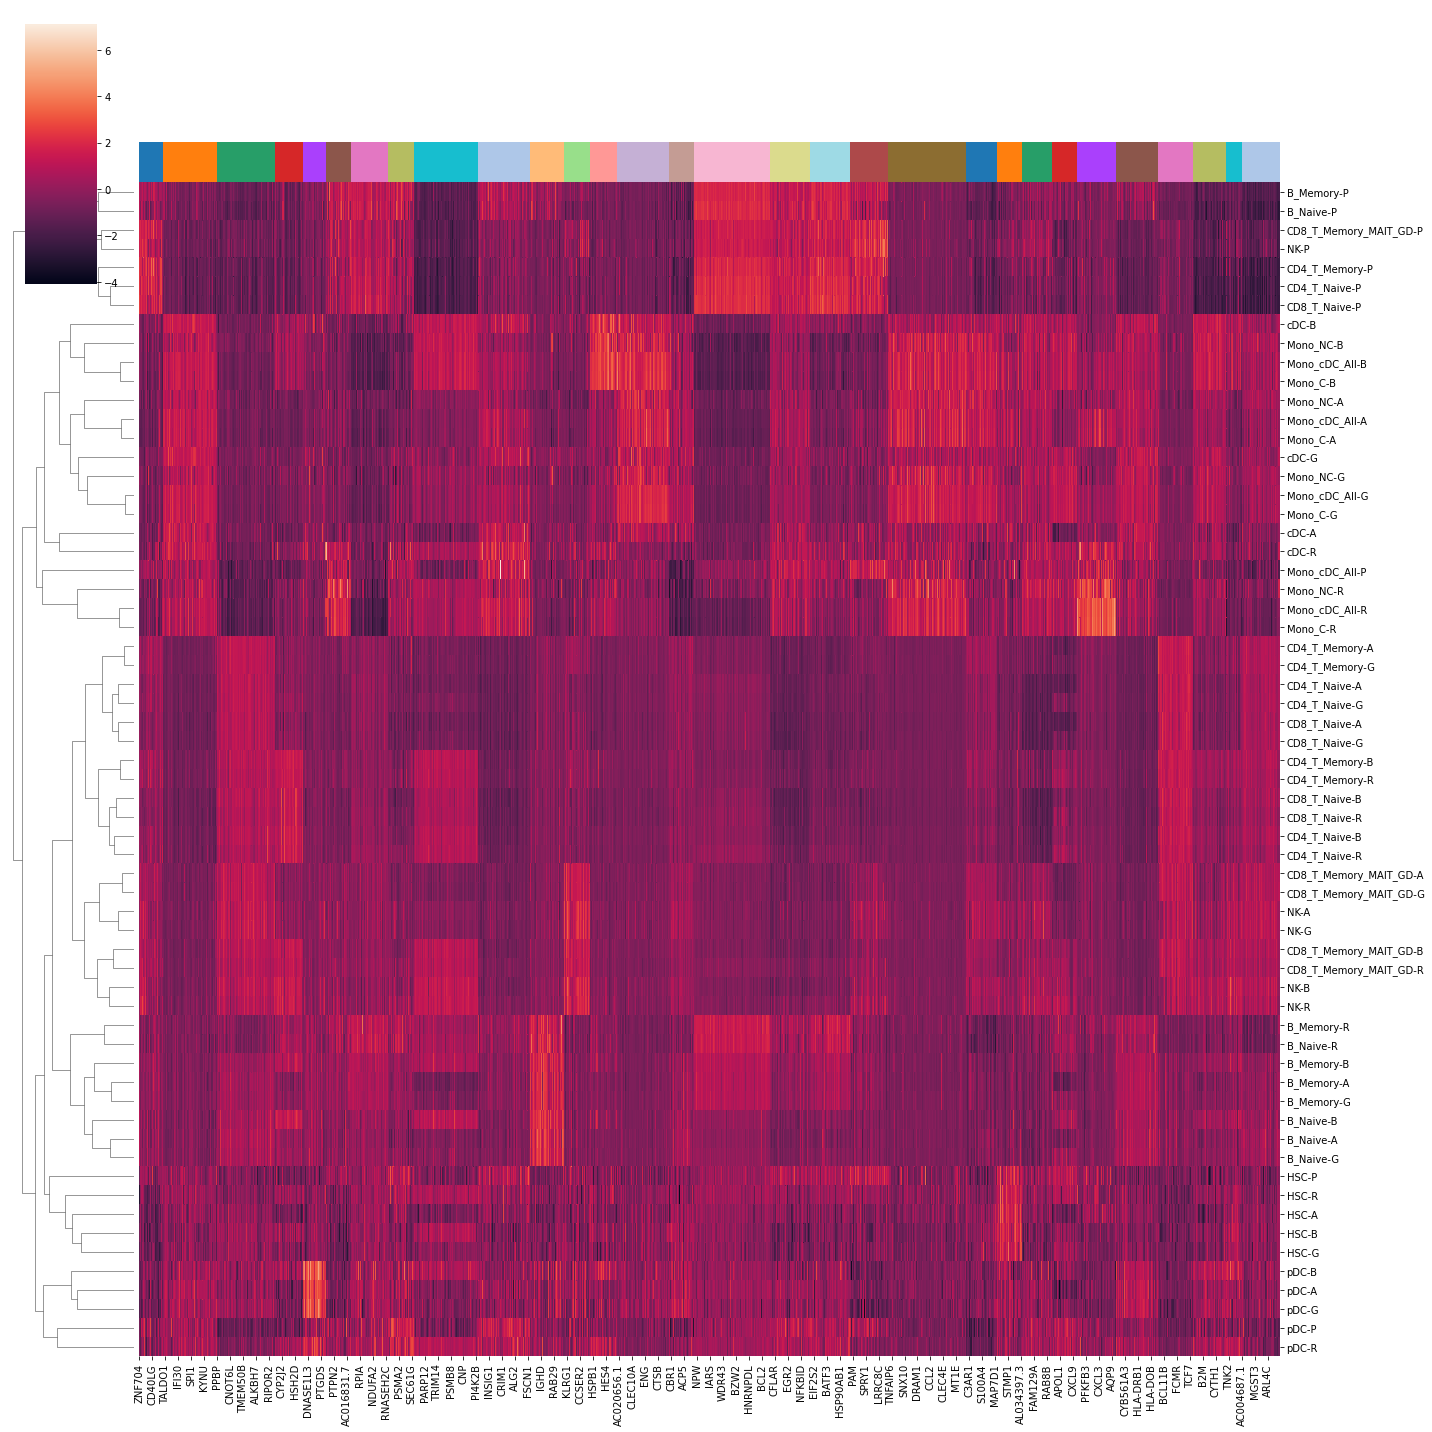

In [49]:
cg = sns.clustermap(df_de.iloc[:,np.argsort(kmeans.labels_)], figsize=(20,20), 
                    row_cluster=True,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    dendrogram_ratio=0.1,
                   );
# plt.tight_layout()

In [50]:
ordered_cts = [i.split('-')[0] for i in df_de.index]
ordered_conds = [i.split('-')[1] for i in df_de.index]

In [51]:
import pickle as pkl

In [52]:
with open(prefix + '../cond.colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

In [53]:
with open(prefix + '../ct.colors.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['hex']

In [54]:
np.setdiff1d(np.unique(ordered_cts), np.array(list(ct_colors.keys())))

array(['Mono_cDC_All'], dtype='<U20')

In [55]:
ct_colors['Mono_cDC_All'] = '#808080' # make it gray

At Jimmie's suggestion, I'm going to make an additional column color to compare the genes that were found differentially expressed in the bulk.

In [71]:
with open(prefix + '../../bulk.jan20/kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'rb') as file:
    bulk_main_modules_genes = pkl.load(file)
    bulk_main_modules_genes = np.unique(np.concatenate([i for i in bulk_main_modules_genes.values()]))

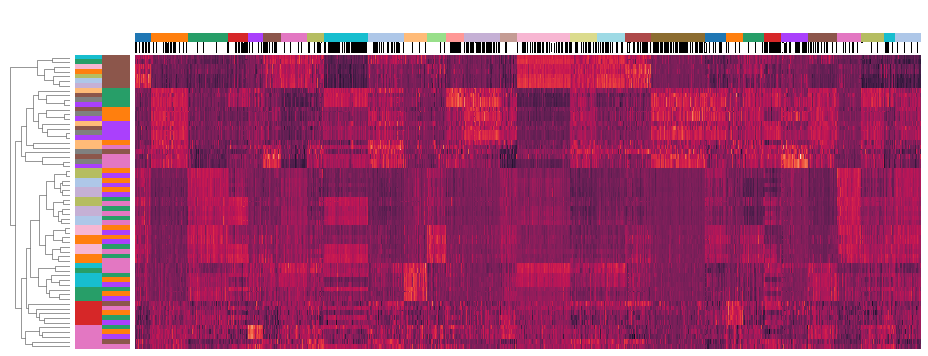

In [74]:
bulk_color = {True: '#000000',
              False: '#FFFFFF'
             }
cg = sns.clustermap(df_de.iloc[:,np.argsort(kmeans.labels_)], figsize=(15,6), 
                    row_cluster=True,
                    col_cluster=False,
                    col_colors=[list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                                list(map(lambda x: bulk_color[x], 
                                         [i in bulk_main_modules_genes for i in df_de.columns[np.argsort(kmeans.labels_)]]))
                               ],
                    row_colors=[list(map(lambda x: ct_colors[x], ordered_cts)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))
                               ],
                    dendrogram_ratio=0.07,
                    cbar_pos=None);
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

Wow, that looks _substantially_ better than hierarchical clustering. KMeans it is. Put them into modules.

In [57]:
main_modules = np.arange(n_clusts)
main_modules_genes = dict(zip(main_modules, [df_de.columns[kmeans.labels_ == i].values for i in range(n_clusts)]))

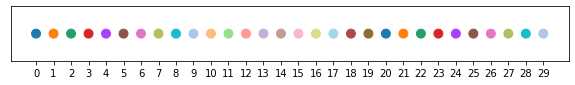

In [58]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

Let's also make some rows for the pseuobulk and bulk data:

In [124]:
with open(prefix + 'pkls/aggr/pseuobulk.conds.inds.norm.pkl', 'rb') as file:
    pseudobulk_cond_inds_norm = pkl.load(file)
with open(prefix + '../../bulk.jan20/counts.norm.pkl', 'rb') as file:
    bulk_cond_inds_norm = pkl.load(file)

Are all the differentially expressed genes at least *found* in the bulk dataset (i.e. the gene all have the same name and were annotated in the bulk pipeline)? For the pseudobulk, the next cell should definitely pass, but for the bulk it might not.

In [93]:
pseudobulk_cond_inds_norm = pseudobulk_cond_inds_norm[df_de.columns.values].copy()
bulk = bulk[df_de.columns.values].copy()

Ahh that's nice.

In [19]:
counts_for_heatmap = pseudobulk_conds_cts.iloc[:,2:]
obs = pd.DataFrame(index=pseudobulk_conds_cts['CT'] + '-' + pseudobulk_conds_cts['COND'])
var = pd.DataFrame(index=pseudobulk_conds_cts.iloc[:,2:].columns)

In [20]:
adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

In [21]:
adata

AnnData object with n_obs × n_vars = 62 × 20303

In [22]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [23]:
adata.raw = adata.copy()

In [24]:
sc.pp.log1p(adata)

In [25]:
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [26]:
df_de = pd.DataFrame(adata[:,all_de_genes].X, index=obs.index, columns=all_de_genes)

In [27]:
df_de.shape

(62, 1583)

## Gene Ontology

Run gene ontology analyses on the modules:

In [188]:
go_files_prefix = '/data/codec/bulk.jan20/' # just use the same one from the bulk analysis, downloads aint working, probably because of firewall
obo_fname = download_go_basic_obo(go_files_prefix + "go-basic.obo")
fin_gene2go = download_ncbi_associations(go_files_prefix + 'gene2go')

  EXISTS: /data/codec/bulk.jan20/go-basic.obo
  EXISTS: /data/codec/bulk.jan20/gene2go


In [189]:
obodag = GODag(go_files_prefix + "go-basic.obo")

/data/codec/bulk.jan20/go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms


In [190]:
# Read NCBI's gene2go. Store annotations in a list of named tuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:04.585154 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: /data/codec/bulk.jan20/gene2go 
CC 18,648 annotated human genes
MF 17,384 annotated human genes
BP 17,541 annotated human genes


In [192]:
gene_ids = list(GeneID2nt_hum.keys())
symbol2geneid = dict(zip([GeneID2nt_hum[i].Symbol for i in gene_ids], [i for i in gene_ids]))

Next cell produces a lot of output, recommend collapsing it in notebook.

In [276]:
results = list()
percent_genes_in_annot = list()
for module in tqdm(main_modules_genes):
    ids = list()

    for i in main_modules_genes[module]:
        try:
            ids.append(symbol2geneid[i])
        except:
            continue
    percent_genes_in_annot.append(len(ids)/len(main_modules_genes[module]))
    
    goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hum.keys(), # List of human protein-coding genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh']) # defult multipletest correction method
    
    goea_results_all = goeaobj.run_study(ids)
    for i in goea_results_all:
        results.append([str(module), i.name, i.NS, -np.log10(i.p_fdr_bh)])


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,711 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,755 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,699 of 20,913 population items found in association

Run BP Gene Ontology Analysis: current study set of 26 IDs ... 96%     25 of     26 study items found in association
100%     26 of     26 study items found in population(20913)
Calculating 12,176 uncorrected p-values using fisher_scipy_stats
  12,176 GO terms are associated with 16,711 of 20,913 population items
     397 GO terms are associated with     25 of     26 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_b

In [277]:
results_df = pd.DataFrame(results, columns=['Module', 'GO_term', 'GO_type', '-log10padj'])

In [278]:
results_df['Module'] = results_df['Module'].astype(np.int)

Visualize the significance levels for the terms found in enriched in each module. BP = biological process, MF = molecular function, CC = cellular component.

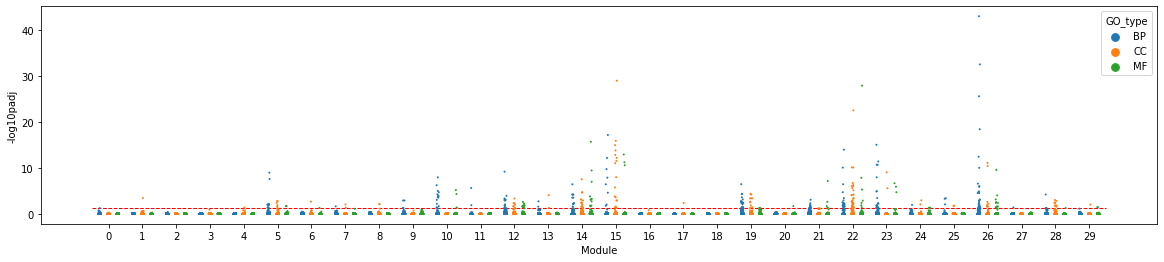

In [279]:
plt.figure(figsize=(20,4))
sns.stripplot(data=results_df,x='Module', hue='GO_type', y='-log10padj', dodge=True, size=2);
plt.plot([-0.5,len(main_modules) - 0.5],[-np.log10(0.05)]*2, linestyle='--', linewidth=1, color='r');

Is the lack of significance from some modules due to the fact that the gene names from that module did not exactly match gene names in the gene ontology dictionary?

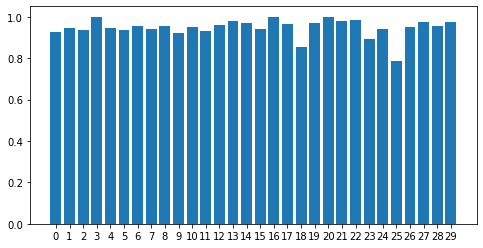

In [280]:
plt.figure(figsize=(8,4))
plt.bar([str(i) for i in main_modules], percent_genes_in_annot);

I think at least 60% of genes is okay.

### Print out and Explore GO Analysis Results

In [281]:
from IPython.display import display # need this to print out the results without truncation.

In [282]:
sig_dfs = dict()
for module in main_modules:
    df = results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                (results_df['Module'] == module)
               ][['GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False)
    sig_dfs[module] = df.copy()

In [283]:
for module in sig_dfs:
    print((module, len(sig_dfs[module])))

(0, 0)
(1, 1)
(2, 0)
(3, 0)
(4, 1)
(5, 17)
(6, 2)
(7, 3)
(8, 2)
(9, 2)
(10, 18)
(11, 2)
(12, 28)
(13, 4)
(14, 36)
(15, 29)
(16, 0)
(17, 1)
(18, 0)
(19, 32)
(20, 1)
(21, 15)
(22, 62)
(23, 28)
(24, 6)
(25, 5)
(26, 44)
(27, 1)
(28, 11)
(29, 3)


In [290]:
module = 25
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'MF')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'CC')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'BP')].sort_values('-log10padj', ascending=False).head(5))

,Module,GO_term,GO_type,-log10padj
465532,25,transmembrane signaling receptor activity,MF,-0.0
468325,25,L-fuconate dehydratase activity,MF,-0.0
468295,25,copper ion binding,MF,-0.0
468296,25,UDP-N-acetylglucosamine 2-epimerase activity,MF,-0.0
468297,25,calcium activated cation channel activity,MF,-0.0


,Module,GO_term,GO_type,-log10padj
463801,25,B cell receptor complex,CC,1.812115
463802,25,external side of plasma membrane,CC,1.719117
463803,25,uropod membrane,CC,0.144267
464951,25,interleukin-1 receptor complex,CC,-0.000000
464962,25,transcription factor TFIIF complex,CC,-0.000000


,Module,GO_term,GO_type,-log10padj
451625,25,B cell activation,BP,3.405318
451626,25,B cell receptor signaling pathway,BP,3.286893
451627,25,adaptive immune response,BP,2.071670
451628,25,positive regulation of lipopolysaccharide-mediated signaling pathway,BP,0.790478
451629,25,B cell differentiation,BP,0.612840


In [284]:
sig_modules = np.array([5, 10, 12, 14, 15, 32, 15, 62, 28, 24, 25, 26, 28])
# sig_modules = main_modules

In [285]:
len(sig_modules)

13

In [291]:
for module in sig_modules:
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        print(module)
        
#         display(sig_dfs[module][:10])
        
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'MF'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'CC'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'][:5])


5


,GO_type,GO_term,-log10padj
104232,MF,complement component C5a receptor activity,1.704086
104233,MF,carbohydrate binding,1.704086


,GO_type,GO_term,-log10padj
102501,CC,integral component of plasma membrane,2.807937
102502,CC,extracellular region,2.807937
102503,CC,plasma membrane,2.412683
102504,CC,ficolin-1-rich granule lumen,1.909931
102505,CC,collagen-containing extracellular matrix,1.588451


,GO_type,GO_term,-log10padj
90325,BP,inflammatory response,8.959562
90326,BP,neutrophil degranulation,7.582689
90327,BP,positive regulation of ERK1 and ERK2 cascade,2.186922
90328,BP,positive regulation of cell migration,2.012768
90329,BP,positive regulation of cytosolic calcium ion concentration,2.012768


10


,GO_type,GO_term,-log10padj
194557,MF,CCR chemokine receptor binding,5.203076
194558,MF,chemokine activity,4.309520
194559,MF,CCR1 chemokine receptor binding,1.375999
194560,MF,CCR5 chemokine receptor binding,1.325331


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
180650,BP,monocyte chemotaxis,7.953367
180651,BP,cellular response to interleukin-1,6.242106
180652,BP,lymphocyte chemotaxis,4.985884
180653,BP,neutrophil chemotaxis,4.712757
180654,BP,cytokine-mediated signaling pathway,4.250862


12


,GO_type,GO_term,-log10padj
230687,MF,protein homodimerization activity,2.619780
230688,MF,protein binding,2.291199
230689,MF,GTPase activity,1.874674
230690,MF,ATPase-coupled peptide antigen transmembrane transporter activity,1.855275
230691,MF,ATPase-coupled peptide transmembrane transporter activity,1.855275


,GO_type,GO_term,-log10padj
228956,CC,MHC class I peptide loading complex,3.353650
228957,CC,TAP complex,2.335495
228958,CC,membrane,2.335495
228959,CC,phagocytic vesicle membrane,2.015705
228960,CC,MHC class I protein complex,1.714314


,GO_type,GO_term,-log10padj
216780,BP,interferon-gamma-mediated signaling pathway,9.191482
216781,BP,defense response to virus,3.936734
216782,BP,cellular response to interferon-gamma,3.358809
216783,BP,antigen processing and presentation of peptide antigen via MHC class I,3.122934
216784,BP,type I interferon signaling pathway,3.042289


14


,GO_type,GO_term,-log10padj
266817,MF,RNA binding,15.678725
266818,MF,unfolded protein binding,9.440113
266819,MF,double-stranded RNA binding,6.988148
266820,MF,protein binding,3.798947
266821,MF,translation initiation factor activity,3.275867


,GO_type,GO_term,-log10padj
265086,CC,cytosol,7.530942
265087,CC,chaperonin-containing T-complex,4.711565
265088,CC,membrane,4.664799
265089,CC,nucleolus,3.134723
265090,CC,extracellular exosome,3.134420


,GO_type,GO_term,-log10padj
252910,BP,protein folding,6.444115
252911,BP,positive regulation of protein localization to Cajal body,4.225996
252912,BP,response to unfolded protein,4.225996
252913,BP,positive regulation of establishment of protein localization to telomere,4.165388
252914,BP,protein stabilization,3.533970


15


,GO_type,GO_term,-log10padj
284882,MF,MHC class II receptor activity,12.910278
284883,MF,MHC class II protein complex binding,11.236648
284884,MF,peptide antigen binding,10.584809


,GO_type,GO_term,-log10padj
283151,CC,MHC class II protein complex,28.965823
283152,CC,lysosomal membrane,15.888992
283153,CC,integral component of lumenal side of endoplasmic reticulum membrane,14.951080
283154,CC,clathrin-coated endocytic vesicle membrane,13.806057
283155,CC,transport vesicle membrane,12.846696


,GO_type,GO_term,-log10padj
270975,BP,antigen processing and presentation of exogenous peptide antigen via MHC class II,17.172142
270976,BP,adaptive immune response,12.177685
270977,BP,interferon-gamma-mediated signaling pathway,9.753684
270978,BP,immune response,7.887890
270979,BP,T cell receptor signaling pathway,6.439848


32


KeyError: 32

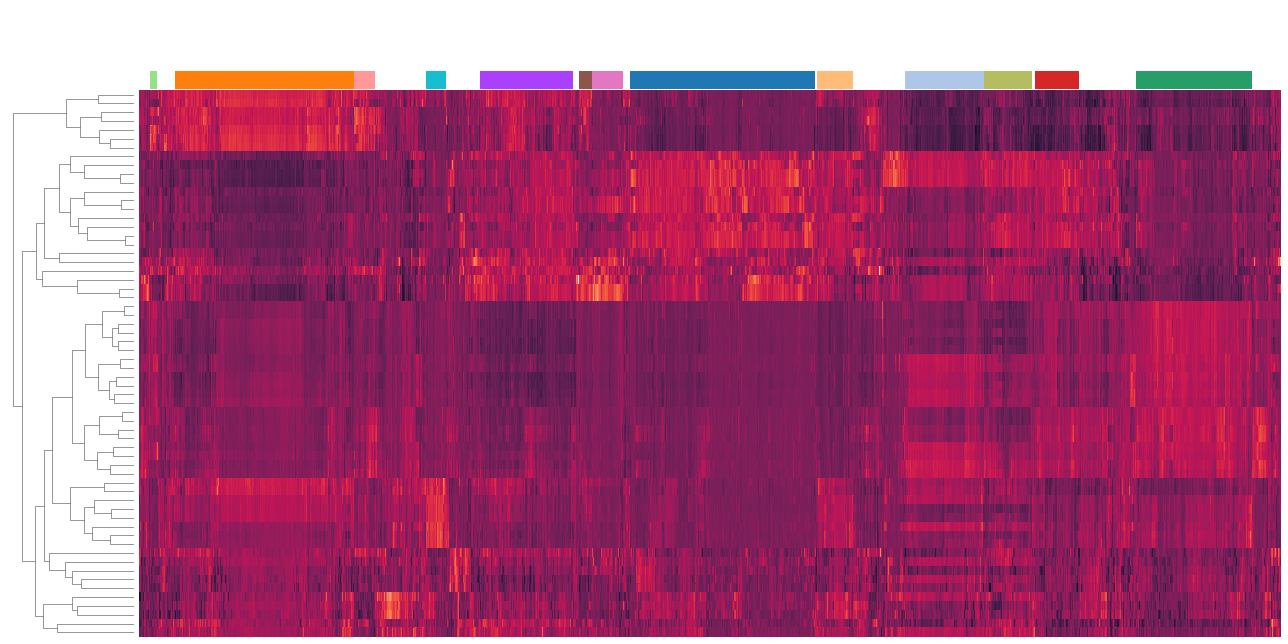

In [158]:
colorful_colors = sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))
colors = colorful_colors[:len(sig_modules)] + ['#FFFFFF']*(num_modules-len(sig_modules))
color_dict = dict(zip(np.concatenate((sig_modules, np.setdiff1d(np.arange(num_modules),sig_modules))), colors))

genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

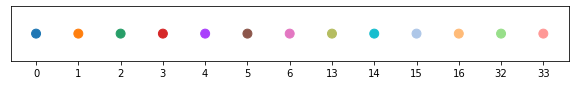

In [159]:
plt.figure(figsize=(10,1))
plt.scatter(list(sig_modules.astype(str)), [1]*len(sig_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], sig_modules))), s=80);
plt.yticks([]);

In [147]:
sig_modules

[0, 1, 2, 3, 4, 5, 6, 13, 14, 15, 16, 32, 33]

In [ ]:
for module in sig_modules:
    print(module)
    print(sig_dfs[module][sig_dfs[module]['GO_term'].str.contains('cAMP')])

In [ ]:
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'])

### Label the Significant Modules

In [337]:
sig_module_labels = {
    1: 'cytokine',
    2: 'neutrophil degranulation',
    6: 'virus',
    8: 'metal ion metabolism',
    10: 'LPS response',
    19: 'cAMP response',
    41: 'MHC binding'
}

In [338]:
len(sig_modules)

7

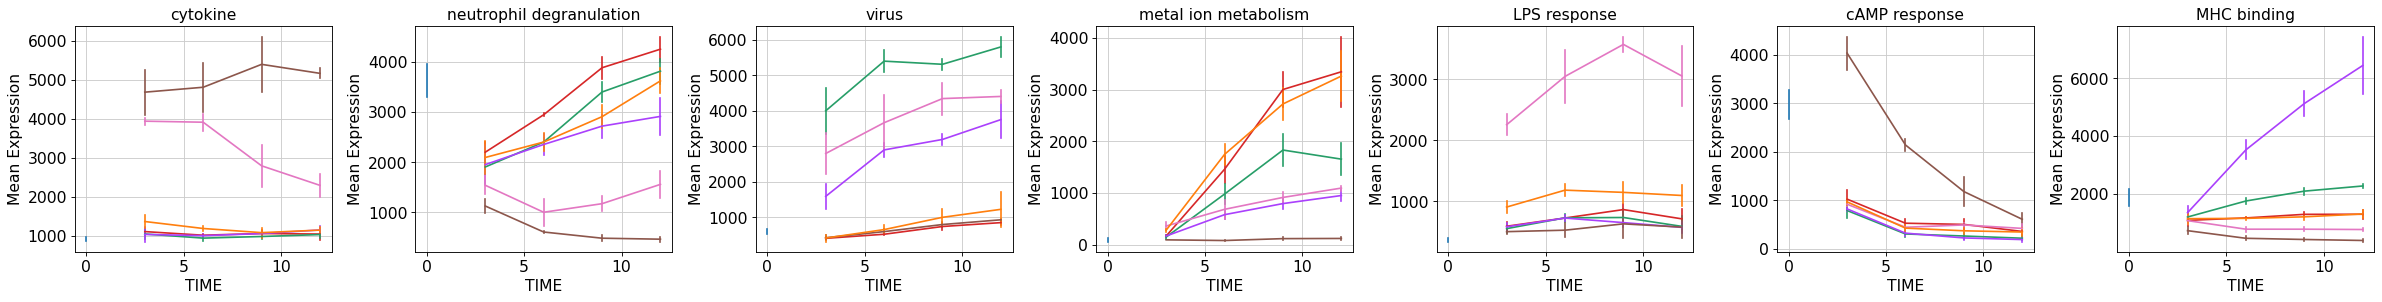

In [339]:
fig, ax = plt.subplots(1, 7, figsize=(30,4))
for sig_module, ax in zip(sig_modules, np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm'][main_modules_genes[sig_module]]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(str(sig_module_labels[sig_module]))
    ax.get_legend().remove()
plt.tight_layout()

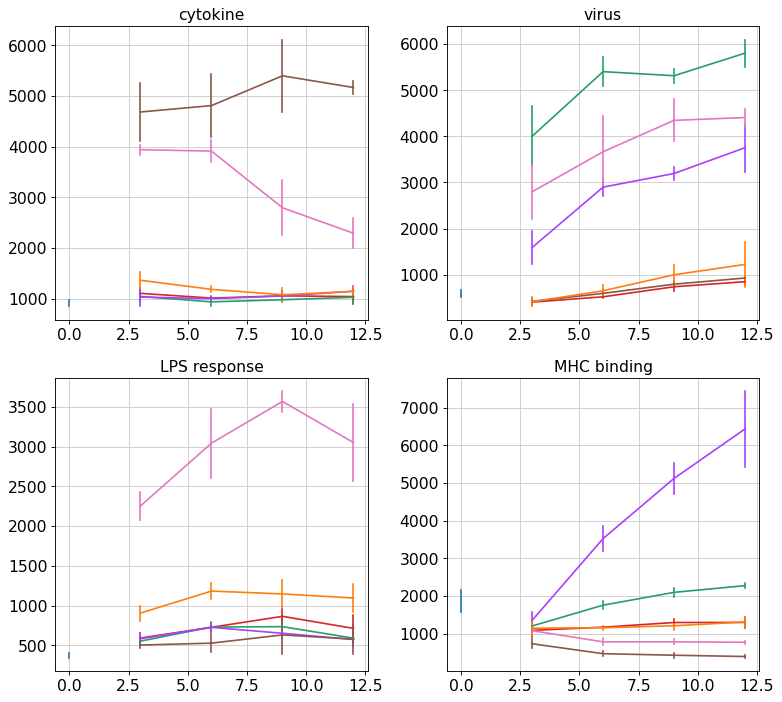

In [347]:
fig, ax = plt.subplots(2, 2, figsize=(10,9))
for sig_module, ax in zip([1, 6, 10, 41], np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm'][main_modules_genes[sig_module]]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(str(sig_module_labels[sig_module]))
    ax.get_legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)
plt.tight_layout()

# Extra

Using the 90th percentile positive log2fc and the p_adj < 0.01, I will now extract out differentially expressed genes.

In [9]:
de_genes = dict() # make a dictionary

for cond in conds_1: # this has all the conditions
    de_genes[cond] = dict() # each value will be each cond, itself be a dictionary with values of cts

In [10]:
# for each cond, each non-zero ct...
combos = list(it.product(conds_1, cts_1)) 
for combo in combos: 
    cond = combo[0]
    ct = combo[1]
    df = de[cond][ct] # get the DE results
    
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    
    # It was in this moment that I realized, the myeloid PMA/I cells also probably capture the cDCs, and
    # therefore they also shouldn't be included in the cDC cell types either, and perhaps Mono_Other_PMA
    # is a misnomer and it should probably be Myeloid_Other_PMA
    # It was for this reason that the log2FoldChange ended up being all negative probably because
    # there was only a handful of cells in the PMAI condition in cDCs
    # therefore, running a check right now to make sure the df isn't empty after subsetting for positive
    # values, but I should go back to the explore.cts notebook when I made the pseuodobulks and reaccount for this
    
    if len(df) == 0:
        continue
    
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct]['-log10padj'] = -np.log10(de_genes[cond][ct]['padj'])

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# for each cond, each non-zero ct...
combos = list(it.product(conds_2, cts_2)) 
for combo in tqdm(combos): 
    cond = combo[0]
    ct = combo[1]
    df = de[cond][ct] # get the DE results
    
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    
    # It was in this moment that I realized, the myeloid PMA/I cells also probably capture the cDCs, and
    # therefore they also shouldn't be included in the cDC cell types either, and perhaps Mono_Other_PMA
    # is a misnomer and it should probably be Myeloid_Other_PMA
    # It was for this reason that the log2FoldChange ended up being all negative probably because
    # there was only a handful of cells in the PMAI condition in cDCs
    # therefore, running a check right now to make sure the df isn't empty after subsetting for positive
    # values, but I should go back to the explore.cts notebook when I made the pseuodobulks and reaccount for this
    
    if len(df) == 0:
        continue
    
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct]['-log10padj'] = -np.log10(de_genes[cond][ct]['padj'])

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
num_genes = pd.DataFrame(index=conds_1, columns=cts_1)
for cond in conds_1:
    for ct in cts_1:
        num_genes.loc[cond, ct] = len(de_genes[cond][ct])

In [13]:
num_genes

,B_Memory,B_Naive,CD4_T_Memory,CD4_T_Naive,CD8_T_Memory_MAIT_GD,CD8_T_Naive,HSC,NK,pDC,Mono_cDC_All
A,0,0,3,58,8,10,45,8,135,392
B,502,609,396,706,460,251,79,480,651,493
G,106,157,21,287,0,61,52,0,0,653
P,880,666,442,808,591,790,232,474,408,1001
R,888,926,547,839,613,330,169,585,842,656


In [14]:
num_genes = pd.DataFrame(index=conds_2, columns=cts_2)
for cond in conds_2:
    for ct in cts_2:
        num_genes.loc[cond, ct] = len(de_genes[cond][ct])

In [15]:
num_genes

,Mono_C,Mono_NC,cDC
A,328,48,118
B,477,446,676
G,661,332,484
R,588,425,406


In [16]:
ct_specific_de_genes = dict()

In [17]:
for cond in tqdm(conds_1):
    cond_cts = list(de_genes[cond].keys())
    ct_specific_de_genes[cond] = dict()
    for ct in cond_cts:
        other_ct_de_genes_map = map(lambda ct: de_genes[cond][ct].index.values, [i for i in cond_cts if i != ct])
        other_ct_de_genes = np.unique([i for j in other_ct_de_genes_map for i in j])
        ct_specific_de_genes[cond][ct] = de_genes[cond][ct].loc[np.setdiff1d(de_genes[cond][ct].index.values, other_ct_de_genes)]

In [18]:
num_genes = pd.DataFrame(index=conds_1, columns=cts_1)
for cond in conds_1:
    for ct in cts_1:
        num_genes.loc[cond, ct] = len(ct_specific_de_genes[cond][ct])

In [19]:
num_genes

,B_Memory,B_Naive,CD4_T_Memory,CD4_T_Naive,CD8_T_Memory_MAIT_GD,CD8_T_Naive,HSC,NK,pDC,Mono_cDC_All
A,0,0,0,39,0,0,27,0,104,39
B,31,76,4,143,22,0,2,40,363,8
G,5,16,0,80,0,0,4,0,0,20
P,131,38,11,50,21,51,43,20,150,816
R,104,198,22,145,41,0,6,47,341,29


In [20]:
num_genes = pd.DataFrame(index=conds_2, columns=cts_2)
for cond in conds_2:
    for ct in cts_2:
        num_genes.loc[cond, ct] = len(ct_specific_de_genes[cond][ct])

In [21]:
num_genes

,Mono_C,Mono_NC,cDC
A,5,1,26
B,4,37,127
G,36,38,131
R,3,48,39


In [22]:
de_genes['B']['CD8_T_Memory_MAIT_GD'].sort_values(by='-log10padj', ascending=False)[:20]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10padj
IFIT1,90.366365,4.252715,0.180466,23.565230,8.763288e-123,9.163770e-119,118.037926
IFI6,267.951834,4.325477,0.194701,22.215973,2.407132e-109,1.258569e-105,104.900123
IFIT3,98.862932,4.166066,0.189302,22.007509,2.440392e-107,6.379794e-104,103.195193
RSAD2,54.178603,4.139642,0.188009,22.018350,1.921331e-107,6.379794e-104,103.195193
IFI44L,48.280330,3.950867,0.180428,21.897197,2.762600e-106,5.777702e-103,102.238245
IFIT2,74.719979,3.992685,0.186350,21.425717,7.694150e-102,1.340962e-98,97.872584
MX1,148.391317,3.934166,0.190032,20.702701,3.274925e-95,4.892270e-92,91.310490
OAS3,23.196968,3.748438,0.183734,20.401463,1.622855e-92,2.121274e-89,88.673403
CMPK2,23.917225,3.570004,0.175711,20.317417,9.019903e-92,1.048012e-88,87.979634
HERC5,61.215823,3.596894,0.178918,20.103556,6.869064e-90,7.182981e-87,86.143695
